In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("./../data/clean/races_info_features.csv")

In [4]:
data.columns

Index(['race', 'city', 'region', 'lat', 'lon', 'n_years_existance',
       'entrants_count_avg', 'run_sinusoity', 'run_distance',
       'run_elevationGain', 'run_score', 'bike_sinusoity', 'bike_distance',
       'bike_elevationGain', 'bike_score', 'swim_distance', 'swim_type',
       'ironkids_race', 'attractivity_score', 'wc_slots',
       'distance_to_nearest_shoreline', 'n_metropolitan_cities', 'n_hotels',
       'n_restaurants', 'n_entertainment', 'n_nightlife', 'n_shops',
       'n_bike_shops', 'n_pools', 'n_athletic_centers', 'n_fitness_centers'],
      dtype='object')

In [1]:
# import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import re

import mysql.connector

from config import Cfg as cfg

%matplotlib inline

## Races info

In [67]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [68]:
# -----------
# -- RACES --
# -----------

# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

### what do we have left to work with?

In [69]:
print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Races dataset --
  Number of active races: 159


### Load number of entrants

In [70]:
races_entrants_count = {}
with open("./../data/races/races-athletes-count.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if races_entrants_count.get(data['id']):
            races_entrants_count[data['id']].append(
                { "year": int(data['date'][:4]),
                  "entrants": data['count']
                }
            )
        else:
            races_entrants_count[data['id']] = [
                { "year": int(data['date'][:4]),
                  "entrants": data['count']
                }]

## Sinuosity of route

In [71]:
def get_angle_between(v1, v2, degrees=False):
    angle = np.math.atan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
    if degrees:
        angle = np.degrees(angle)
    return angle

def get_successive_angles(x, y):
    x_diff = x[1:] - x[:-1]
    y_diff = y[1:] - y[:-1]
    angles = []
    for i in range(len(x_diff)-1):
        v1 = [x_diff[i], y_diff[i]]
        v2 = [x_diff[i+1], y_diff[i+1]]
        angles.append(np.abs(get_angle_between(v1, v2, degrees=True)))
    return np.array(angles)

In [72]:
# hash for swim types in db
swim_type = {
    'h': 'harbor',
    'o': 'ocean',
    'l': 'lake',
    'r': 'river'
}

# Constructs data with select features

In [73]:
races_final = df_races.loc[:, ['race', 'city', 'region']]

In [74]:
races_final['lat'] = 0
races_final['lon'] = 0
races_final['n_years_existance'] = 0
races_final['entrants_count_avg'] = 0
races_final['run_sinusoity'] = 0
races_final['run_distance'] = 0
races_final['run_elevationGain'] = 0
races_final['run_score'] = 0
races_final['bike_sinusoity'] = 0
races_final['bike_distance'] = 0
races_final['bike_elevationGain'] = 0
races_final['bike_score'] = 0
races_final['swim_distance'] = 0
races_final['swim_type'] = ''



year_threshold = 2014

for race in races_final.race:
    # avg number of race entrants
    mean_count = 0
    n_years_existance = 0
    race_participation = races_entrants_count.get(race, 0)
    if not race_participation:
        # try with lowercase
        race_participation = races_entrants_count.get(race.lower(), 0)
    if race_participation:
        counts = np.array([y['entrants'] if y['year']>year_threshold else np.nan for y in race_participation]) 
        mean_count = np.nanmean(counts)
        n_years_existance = len(race_participation)
    
    # nan if no results
    mean_count = np.nan if not mean_count else mean_count
    n_years_existance = np.nan if not n_years_existance else n_years_existance
        
    # get lat/lon by averaging run points  
    run_map = json.loads(df_races.loc[df_races.race==race]['map'].values[0])['run']
    run_data = np.array(run_map['points'])
    lon = run_data[:, 0].mean()
    lat = run_data[:, 1].mean()
    # sinusoity of run route
    run_sinusoity = get_successive_angles(run_data[:, 0], run_data[:, 1]).mean()
    
    # sinusoity of bike route
    bike_map = json.loads(df_races.loc[df_races.race==race]['map'].values[0])['bike']
    bike_data = np.array(bike_map['points'])
    bike_sinusoity = get_successive_angles(bike_data[:, 0], bike_data[:, 1]).mean()
    
    # infos
    infos = json.loads(df_races.loc[df_races.race==race]['info'].values[0])
    
    races_final.loc[ 
        races_final.race == race, 
        ['lat', 
         'lon', 
         'n_years_existance',
         'entrants_count_avg',
         'run_sinusoity',
         'run_distance',
         'run_elevationGain',
         'run_score',
         'bike_sinusoity',
         'bike_distance',
         'bike_elevationGain',
         'bike_score',
         'swim_distance',
         'swim_type'
        ]] = [
         lat, 
         lon, 
         n_years_existance,
         mean_count, 
         run_sinusoity,
         infos['run']['distance'],
         infos['run']['elevationGain'],
         infos['run']['score'],
         bike_sinusoity,
         infos['bike']['distance'],
         infos['bike']['elevationGain'],
         infos['bike']['score'],
         infos['swim']['distance'],
         swim_type[infos['swim']['type']]
        ]
    

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


In [75]:
# save data to use by all the geo API
races_final[['race', 'lat', 'lon']].to_csv("./../data/geo-data/races_lat_lon.csv", index=False)

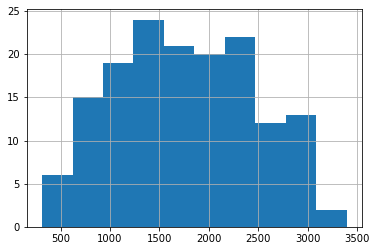

In [76]:
races_final.entrants_count_avg.hist()

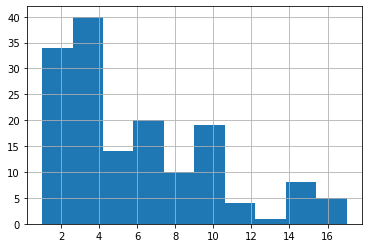

In [77]:
races_final.n_years_existance.hist()

## Does race have a ironKids race ?

Try to get the race by crossing websites information with the race list

In [78]:
ironKids_races = {}
with open("./../data/races/ironKids-races.json") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        ironKids_races[data['name'].strip().replace("IRONKIDS ", "")] = data
        
all_races = {}
with open("./../data/races/races.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        all_races[data['website'].split('.asp')[0]] = data
  
not_matched = []
for kidsrace in ironKids_races:
    # try to find a match in all_races dataset
    url = ironKids_races[kidsrace]['url']
    match = 0
    duplicate = 0
    for race in all_races:
        if re.match(race, url):
            # try first to match parent website
            ironKids_races[kidsrace]['race_parent'] = all_races[race]['id']
            match = 1
            
        if not match:
            # there is a bunch of Fun Run in races title, try to match name without
            stripped_name = kidsrace.replace(" Fun Run", "")
            if stripped_name in all_races[race]['name']:
                ironKids_races[kidsrace]['race_parent'] = all_races[race]['id']
                match = 1
                # get my attention if we match several races
                duplicate+=1
                if duplicate>1:
                    print("---- duplicate ----", duplicate, kidsrace)     
            
    if not match:
        not_matched.append(kidsrace)
        print(kidsrace, "-->", ironKids_races[kidsrace]['url'])

Cambridge Fun Run --> http://www.ironman.com/triathlon/events/americas/ironkids/eagleman.aspx
Warsaw --> http://www.ironman.com/triathlon/events/emea/ironkids/ironkids-warsaw.aspx
Les Sables dOlonne --> http://www.ironman.com/triathlon/events/emea/ironman-70.3/les-sables-dolonne/athletes/ironkids.aspx
Haugesund Norway --> http://www.ironman.com/triathlon/events/emea/ironkids/ironkids-norway.aspx
Coeur d Alene Fun Run --> http://www.ironman.com/triathlon/events/americas/ironkids/coeur-d-alene.aspx
Westfriesland --> http://www.ironman.com/triathlon/events/emea/multisport/multisport-westfriesland/ironkids.aspx
Vitoria-Gasteiz --> http://www.ironman.com/triathlon/events/emea/ironman/vitoria-gasteiz/side-events/ironkids.aspx
Dip 'N' Dash Lake Placid --> http://www.ironman.com/triathlon/events/americas/ironkids/lake-placid-dip-n-dash.aspx
Subaru Canada Fun Run --> http://www.ironman.com/triathlon/events/americas/ironkids/canada.aspx
Sonoma County Builders Santa Rosa Fun Run --> http://www.ir

In [79]:
# manually match the ones left
manual_matches = {
    "Cambridge Fun Run": "eagleman70.3",
    "Warsaw": None, # new race
    "Les Sables dOlonne": None, # new race
    "Haugesund Norway": "haugesund",
    "Coeur d Alene Fun Run": "coeurdalene70.3",
    "Westfriesland": None, # irrelevant, own festival
    "Vitoria-Gasteiz": None, # new race
    "Dip 'N' Dash Lake Placid": None, # irrelevant, own festival
    "Subaru Canada Fun Run": "canada", 
    "Sonoma County Builders Santa Rosa Fun Run": "santarosa70.3",
    "Lake Placid 70.3 Fun Run": "lakeplacid70.3",
    "Superfrog Fun Run": "superfrog70.3",
    "Alpharetta": None, # new race
    "Keiki Dip 'n Dash": None, # new race
    "Mar del Plata": None, # new race
    "Clearwater Fun Run": None, # other festival 
    "Galveston Fun Run": None, # new race and will be for Texas 70.3 commemorative year
    "Dip 'N' Dash Florida": "florida70.3"
}

for kidsrace in manual_matches:
    ironKids_races[kidsrace]['race_parent'] = manual_matches[kidsrace]
    

In [80]:
# make sure we covered everything
for kidsrace in ironKids_races:
    if ironKids_races[kidsrace].get('race_parent', 10) == 10:
        print(ironKids_races)
        
races_parent = []
for kidsrace in ironKids_races:
    prace = ironKids_races[kidsrace]['race_parent']
    if prace: # some are set to None
        races_parent.append(prace)

races_final['ironkids_race'] = 0
for race in races_parent:
    if races_final.race.str.contains(f"{race}$").sum() > 0:
        races_final.loc[races_final.race == race, 'ironkids_race'] = 1
#         races_final.loc[races_final.race.str.contains(f"{race}$"), 'ironkids_race'] = 1
    else:
        print(race)
        
races_final.head()

uk70.3
maastricht
aarhus70.3


,race,city,region,lat,lon,n_years_existance,entrants_count_avg,run_sinusoity,run_distance,run_elevationGain,run_score,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race
5,alagoas70.3,"Macei, Alagoas Brazil",South America,-9.661669,-35.701667,2.0,1184.00,4.617878,20880.8,219.2,1.3,2.783388,89332.1,506.7,0.8,1949.4,ocean,0
6,arizona,"Tempe, AZ",North America,33.433518,-111.937962,15.0,2916.75,9.242414,41597.4,178.5,0.9,3.839884,178983.9,500.3,0.7,3767.4,lake,1
7,Arizona70.3,"Tempe, Arizona",North America,33.432270,-111.932982,4.0,1738.00,7.081167,20812.2,101.4,0.4,8.599225,87609.5,505.0,1.2,2010.0,river,0
8,astana70.3,"Astana, Kazakhstan",Middle East,51.125358,71.453152,1.0,1086.00,7.975205,20643.3,81.3,0.5,3.520386,89303.6,249.7,0.3,1903.7,river,1
9,atlanticcity70.3,"Atlantic City, New Jersey",North America,39.350119,-74.449387,3.0,2250.00,7.781190,20883.8,88.9,0.5,3.816421,89840.0,293.7,0.6,1928.4,harbor,1


## Race attractivity

Do athletes who have the possibility of coming back to the race actually returns?

In [81]:
# need results data for that
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [82]:
# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(races_final['race'])]

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019 since year is running currently
df_results = df_results.loc[df_results['year'] < 2019]

# add years in sport
years_in_sport = (df_results
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('years_in_sport') 
)

df_results = df_results.merge(years_in_sport, left_on="athlete", right_on="athlete", how="left")
df_results['years_in_sport'] = df_results.years_in_sport.astype(int)

len(df_results)

1677097

In [83]:
# keep only athletes that have done more than one season
# so they had the ability to redo the same race if they wanted
df_multi_season = df_results.loc[df_results["years_in_sport"]>1]

# number of editions of the race
n_editions = (df_multi_season 
        .groupby(['race', 'year'])
        .size()
        .reset_index()
        .groupby('race')
        .size()
        .rename("n_edition")
)

# how many times races have been raced by those multi-season athletes?
total_hits  = (
    df_multi_season 
        .groupby(['race'])
        .size()
        .reset_index()
        .rename(columns={0: "total_hits"})
)

# how many times multi-season athletes returned to race again the same race?
returned_hits = (
    df_multi_season 
        .groupby(['race', 'athlete'])
        .size()
        .reset_index()
        .groupby('race')
        .size()
        .rename("returned_hits")
)


results = (
    total_hits
        .merge(returned_hits, left_on="race", right_on="race", how="left")
        .merge(n_editions, left_on="race", right_on="race", how="left")
)
results["ratio"] = results['returned_hits']/results['total_hits']
results.head()

,race,total_hits,returned_hits,n_edition,ratio
0,Arizona70.3,5064,4032,4,0.796209
1,DunLaoghaire70.3,800,789,1,0.986250
2,Florianopolis70.3,609,608,1,0.998358
3,Haugesund70.3,2406,1516,4,0.630091
4,IMsubicbay,1036,1034,1,0.998069


Only the races with more than 1 editions have potential returning entrants. If returned hits is < than total_hits it means there are entrants with same name

In [84]:
len(results.loc[results.n_edition > 1])

138

Weighted ratio:

$$WR=(\frac{v}{v+m}*R) + (\frac{m}{v+m}*C)$$

where:
- $v$ is the number of valid competitors (at least 2 years of experience in the sport) who entered the race
- $m$ is the minimum number of competitors required to be listed in the chart
- $R$ is the ratio of returning competitors from the valid competitor pool
- $C$ is the mean returning ratio across the whole report

In [85]:
races_attractivity_score = results.copy()
# keep only races with >1 editions
races_attractivity_score = races_attractivity_score.loc[races_attractivity_score.n_edition>1]

c = races_attractivity_score.ratio.mean()

m = races_attractivity_score["total_hits"].quantile(0.6)


# Function that computes the weighted ratio of each race
def weighted_ratio(df, m=m, C=c):
    v = df['total_hits']
    R = df['ratio']
    # Calculation based on the IMDB formula
    return ((v/(v+m) * R) + (m/(m+v) * C))

races_attractivity_score["attractivity_score"] = races_attractivity_score.apply(weighted_ratio, axis=1)

In [86]:
races_attractivity_score.sort_values('attractivity_score', ascending=False).head()

,race,total_hits,returned_hits,n_edition,ratio,attractivity_score
17,barcelona,10600,9034,5,0.852264,0.796820
51,emiliaromagna,4023,3766,2,0.936117,0.794627
38,chattanooga,11356,9511,5,0.837531,0.790483
75,lakeplacid70.3,3786,3510,2,0.927100,0.789088
142,vichy,4463,4007,4,0.897827,0.786203


In [87]:
# add back the races with just 1 edition and fill na
race_attractivity = pd.concat([races_attractivity_score, results.loc[results.n_edition == 1]], sort=False).fillna(races_attractivity_score.median())
race_attractivity.head()

,race,total_hits,returned_hits,n_edition,ratio,attractivity_score
0,Arizona70.3,5064,4032,4,0.796209,0.753045
3,Haugesund70.3,2406,1516,4,0.630091,0.705584
5,Maastricht,2926,2647,3,0.904648,0.772855
7,Vietnam70.3,2895,2275,4,0.785838,0.742129
8,alagoas70.3,1050,896,2,0.853333,0.741099


In [92]:
races_final = races_final.merge(race_attractivity[['race', 'attractivity_score']], left_on="race", right_on="race", how="left")
races_final.head()

,race,city,region,lat,lon,n_years_existance,entrants_count_avg,run_sinusoity,run_distance,run_elevationGain,run_score,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score
0,alagoas70.3,"Macei, Alagoas Brazil",South America,-9.661669,-35.701667,2.0,1184.00,4.617878,20880.8,219.2,1.3,2.783388,89332.1,506.7,0.8,1949.4,ocean,0,0.741099
1,arizona,"Tempe, AZ",North America,33.433518,-111.937962,15.0,2916.75,9.242414,41597.4,178.5,0.9,3.839884,178983.9,500.3,0.7,3767.4,lake,1,0.688499
2,Arizona70.3,"Tempe, Arizona",North America,33.432270,-111.932982,4.0,1738.00,7.081167,20812.2,101.4,0.4,8.599225,87609.5,505.0,1.2,2010.0,river,0,0.753045
3,astana70.3,"Astana, Kazakhstan",Middle East,51.125358,71.453152,1.0,1086.00,7.975205,20643.3,81.3,0.5,3.520386,89303.6,249.7,0.3,1903.7,river,1,0.728331
4,atlanticcity70.3,"Atlantic City, New Jersey",North America,39.350119,-74.449387,3.0,2250.00,7.781190,20883.8,88.9,0.5,3.816421,89840.0,293.7,0.6,1928.4,harbor,1,0.733810


In [93]:
len(races_final)

159

## World Championship qualifyiers

In [94]:
qualifyiers = pd.read_csv("./../data/races/qualifyiers-slots.csv")
qualifyiers.head()

,AG Slots,Avg.,Competition,Date,Date,First,Last,Location,Slots
0,2.0,04:01:52,Ironman 70.3 Xiamen,NaN,11/18/2018,04:01:36,04:02:08,NaN,30.0
1,1.0,04:12:02,Ironman 70.3 Liuzhou,NaN,04/14/2019,04:12:02,04:12:02,NaN,25.0
2,1.0,04:14:34,Ironman 70.3 Hawaii,NaN,06/01/2019,04:14:34,04:14:34,NaN,30.0
3,1.0,08:22:23,Ironman Louisville,NaN,10/14/2018,08:22:23,08:22:23,NaN,40.0
4,2.0,08:24:44,Ironman Chattanooga,NaN,09/30/2018,08:16:00,08:33:28,NaN,40.0


In [95]:
races_final["wc_slots"] = 0

for race,slots in qualifyiers.loc[:, ["Competition", "Slots"]].values:
    racename = race.split("Ironman ")[1].lower()
        
    isHalf = False
    match = []
    if "70.3" in race:
        isHalf = True
        racename = racename.replace("70.3 ", "")
    racename = racename.replace("-", "").replace(" ", "")
    candidates = races_final.loc[races_final.race.str.contains(f"^{racename}", regex=True)==True, 'race'].values
    if isHalf:
        for c in candidates:
            if "70.3" in c:
                match.append(c)
    else:
        for c in candidates:
            if "70.3" not in c:
                match.append(c)
                
    if len(match)>0:
        races_final.loc[races_final.race == match[0], 'wc_slots'] = slots
#         print(races_final.loc[races_final.race == match[0], 'wc_slots'])
#     print(racename, match)

races_final.head()

,race,city,region,lat,lon,n_years_existance,entrants_count_avg,run_sinusoity,run_distance,run_elevationGain,run_score,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score,wc_slots
0,alagoas70.3,"Macei, Alagoas Brazil",South America,-9.661669,-35.701667,2.0,1184.00,4.617878,20880.8,219.2,1.3,2.783388,89332.1,506.7,0.8,1949.4,ocean,0,0.741099,0.0
1,arizona,"Tempe, AZ",North America,33.433518,-111.937962,15.0,2916.75,9.242414,41597.4,178.5,0.9,3.839884,178983.9,500.3,0.7,3767.4,lake,1,0.688499,40.0
2,Arizona70.3,"Tempe, Arizona",North America,33.432270,-111.932982,4.0,1738.00,7.081167,20812.2,101.4,0.4,8.599225,87609.5,505.0,1.2,2010.0,river,0,0.753045,0.0
3,astana70.3,"Astana, Kazakhstan",Middle East,51.125358,71.453152,1.0,1086.00,7.975205,20643.3,81.3,0.5,3.520386,89303.6,249.7,0.3,1903.7,river,1,0.728331,0.0
4,atlanticcity70.3,"Atlantic City, New Jersey",North America,39.350119,-74.449387,3.0,2250.00,7.781190,20883.8,88.9,0.5,3.816421,89840.0,293.7,0.6,1928.4,harbor,1,0.733810,0.0


# Add geo features from other API

### Distance to nearest coastline

In [96]:
# coastline data
shorelines = pd.read_csv('./../data/geo-data/shorelines_lat_lon.csv')
shorelines.head()

#HAVERSINE FUNCTION
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    lon1_rad = np.radians(lon1)
    lon2_rad = np.radians(lon2)
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    a = np.sqrt((np.sin(delta_lat/2))**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * (np.sin(delta_lon/2))**2 )
    d = 2 * 6371000 * np.arcsin(a)
    return d

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')



In [97]:
races_final['distance_to_nearest_shoreline'] = 0

for race in races_final.race:
    lat,lon = races_final.loc[races_final.race == race, ['lat', 'lon']].values[0]
    races_final.loc[races_final.race == race, 'distance_to_nearest_shoreline'] = np.min(
        haversine(shorelines.lat, shorelines.lon, lat, lon)/1000 # in km
    )

In [98]:
races_final.sort_values(by="distance_to_nearest_shoreline").head()

,race,city,region,lat,lon,n_years_existance,entrants_count_avg,run_sinusoity,run_distance,run_elevationGain,...,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score,wc_slots,distance_to_nearest_shoreline
101,Nice70.3,"Nice, France",Europe,43.684918,7.241314,1.0,2707.0,3.400506,20777.1,74.6,...,13.897903,90922.1,1461.0,4.1,2094.0,ocean,0,0.728331,0.0,0.029552
53,france,"Nice, France",Europe,43.684857,7.241084,14.0,2623.0,4.845118,41103.8,95.8,...,21.571045,171596.8,3166.9,4.9,3885.2,ocean,1,0.716845,40.0,0.047496
37,CostaNavarino70.3,Greece,Europe,36.976010,21.673965,1.0,1367.0,7.221401,20560.9,166.5,...,4.306426,88477.7,1352.0,3.6,1504.0,ocean,0,NaN,0.0,0.292885
14,bintan70.3,"Bintan, Indonesia",Asia,1.173083,104.377244,4.0,821.0,11.894758,20761.9,217.9,...,5.708991,88869.4,802.7,1.7,2011.9,ocean,0,0.730825,0.0,0.402116
42,DunLaoghaire70.3,"Dun Laoghaire, Ireland",Europe,53.295280,-6.133746,1.0,1663.0,6.646245,21206.2,136.8,...,7.038661,85997.2,1390.0,4.3,1910.1,ocean,0,0.728331,0.0,0.441513


## "Touristicity" of a race

In [107]:
races_final['n_metropolitan_cities'] = 0
races_final['n_hotels'] = 0
races_final['n_restaurants'] = 0
races_final['n_entertainment'] = 0
races_final['n_nightlife'] = 0
races_final['n_shops'] = 0
races_final['n_bike_shops'] = 0
races_final['n_pools'] = 0
races_final['n_athletic_centers'] = 0
races_final['n_fitness_centers'] = 0

distance = 100


# metropolitan area
with open("./../data/geo-data/races-metropolitan-area.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_metropolitan_cities'] = data[race]['totalCount']
    
# hotels
with open(f"./../data/geo-data/races-poi-hotels-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_hotels'] = data[race]['poi_n_results']
    
# restaurants
with open(f"./../data/geo-data/races-poi-food-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_restaurants'] = data[race]['poi_n_results']
    
# entertainment
with open(f"./../data/geo-data/races-poi-entertainment-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_entertainment'] = data[race]['poi_n_results']
    
# nightlife
with open(f"./../data/geo-data/races-poi-nightlife-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_nightlife'] = data[race]['poi_n_results']
    
# shops
with open(f"./../data/geo-data/races-poi-shops_services-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_shops'] = data[race]['poi_n_results']

# bike shops
with open(f"./../data/geo-data/races-poi-shops_bike-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_bike_shops'] = data[race]['poi_n_results']

# pools
with open(f"./../data/geo-data/races-poi-pool-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_pools'] = data[race]['poi_n_results']

# athletic centers
with open(f"./../data/geo-data/races-poi-athletic_centers-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_athletic_centers'] = data[race]['poi_n_results']

# fitness centers
with open(f"./../data/geo-data/races-poi-fitness_centers-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_fitness_centers'] = data[race]['poi_n_results']
    
races_final.head()

,race,city,region,lat,lon,n_years_existance,entrants_count_avg,run_sinusoity,run_distance,run_elevationGain,...,n_metropolitan_cities,n_hotels,n_restaurants,n_entertainment,n_nightlife,n_shops,n_bike_shops,n_pools,n_athletic_centers,n_fitness_centers
0,alagoas70.3,"Macei, Alagoas Brazil",South America,-9.661669,-35.701667,2.0,1184.00,4.617878,20880.8,219.2,...,1,182,227,60,73,196,17,19,137,134
1,arizona,"Tempe, AZ",North America,33.433518,-111.937962,15.0,2916.75,9.242414,41597.4,178.5,...,5,283,239,210,245,249,177,211,243,246
2,Arizona70.3,"Tempe, Arizona",North America,33.432270,-111.932982,4.0,1738.00,7.081167,20812.2,101.4,...,5,283,239,210,245,249,177,210,243,246
3,astana70.3,"Astana, Kazakhstan",Middle East,51.125358,71.453152,1.0,1086.00,7.975205,20643.3,81.3,...,1,76,58,26,39,124,6,9,52,40
4,atlanticcity70.3,"Atlantic City, New Jersey",North America,39.350119,-74.449387,3.0,2250.00,7.781190,20883.8,88.9,...,23,238,244,179,248,138,110,125,134,144


In [108]:
races_final.columns

Index(['race', 'city', 'region', 'lat', 'lon', 'n_years_existance',
       'entrants_count_avg', 'run_sinusoity', 'run_distance',
       'run_elevationGain', 'run_score', 'bike_sinusoity', 'bike_distance',
       'bike_elevationGain', 'bike_score', 'swim_distance', 'swim_type',
       'ironkids_race', 'attractivity_score', 'wc_slots',
       'distance_to_nearest_shoreline', 'n_metropolitan_cities', 'n_hotels',
       'n_restaurants', 'n_entertainment', 'n_nightlife', 'n_shops',
       'n_bike_shops', 'n_pools', 'n_athletic_centers', 'n_fitness_centers'],
      dtype='object')

## SAVE FINAL FILE

In [100]:
# save final
races_final.to_csv("./../data/clean/races_info_features.csv", index=False)